In [3]:
import time
import serial
import matplotlib.pyplot as plt
# To find port: python -m serial.tools.list_ports
import struct
import pandas as pd

In [4]:
!python -m serial.tools.list_ports

/dev/ttyUSB0        
1 ports found


In [6]:
def read_measurements_raw(port='/dev/ttyUSB0', duration=10):
    ser = serial.Serial(port=port, baudrate=115200, bytesize=8, parity='N', stopbits=1) # To find port: python -m serial.tools.list_ports
    measurements = []
    start = time.time()
    while time.time() - start < duration:
        ser.write(b'\x01\x03\x00\xc8\x00\x10\xc5\xf8') # All channels float
        measurements.append((time.time(), ser.read(37)))
    ser.close()
    return measurements[1:]

def bytesToFloat(h1,h2,h3,h4):
    ba = bytearray()
    ba.append(h1)
    ba.append(h2)
    ba.append(h3)
    ba.append(h4)
    return struct.unpack("!f",ba)[0]

def measurements_to_df(measurement_bytes):
    dict_list = []
    for ans in measurement_bytes:
        row = {}
        row['time_stamp'] = ans[0]
        measure = ans[1]
        for i in range(6):
            pos = 3+4*i
            row[f'sensor_{i+1}'] = bytesToFloat(measure[pos], measure[pos+1], measure[pos+2], measure[pos+3])
        dict_list.append(row)
    return pd.DataFrame(dict_list)

def read_measurements_df(port='/dev/ttyUSB0', duration=10, calibration=True):
    if calibration: # TODO: Must recheck calibration idea, as when Batbot is mounted it already has a force that can't be calibrated to zero.
        shift = measurements_to_df(read_measurements_raw(port=port, duration=1)).drop('time_stamp', axis=1).mean()
        shift['time_stamp']=0.0
    else:
        shift = 0
    return measurements_to_df(read_measurements_raw(port=port, duration=duration)) - shift

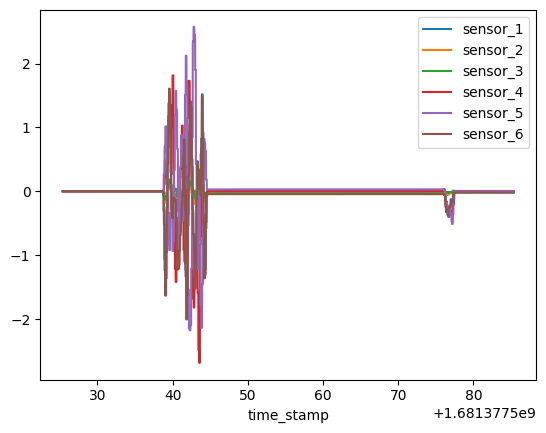

In [13]:
df = read_measurements_df(duration=60)
df.plot(x='time_stamp')
plt.show()